In [4]:
import numpy as np
import matplotlib
import pylab as p
import os
import matplotlib.pyplot as plt

def plot_X_life(pop, X, xlab, ylab, save_name, int_1, int_2, meansd,save_dir):

  font = {'size'   : 14}
  matplotlib.rc('font', **font)

  logit = True
  f1 = p.figure()
  tmp=[]
  
  #zahl=2000
  #tmp2=zeros((zahl,zahl),dtype=float)

  zahl = max([len(cell.species[X]) for cell in pop]) # "zahl" is the simulation time of the oldest cell
  nr_cells=len(pop)
  tmp2=np.zeros((nr_cells,zahl),dtype=float)
  
  tmp_mn=[]
  tmp_sd=[]
  i=1
  for k1, cell in enumerate(pop):
    if np.any(cell.species[X]):
      if meansd:
        tmp.append(cell.species[X])
      else:
        #p.plot(range(len(vector[X])),vector[X])
        for k2, v in zip(range(zahl-len(cell.species[X]),zahl),cell.species[X]):
          tmp2[k1,k2] = v
        if not logit and len(cell.species[X])>=int_1 and i <= int_2:
          p.plot(range(zahl-len(cell.species[X]),zahl),cell.species[X], alpha=0.1)
          i += 1
        elif len(cell.species[X])>=int_1 and i <= int_2:
          p.plot(range(zahl-len(cell.species[X]),zahl),np.log10(cell.species[X]), alpha=0.1) #log-scale
          #p.xlim(400,600)
          i += 1
  for m in range(zahl):
    if not logit: tmp_list=[n for n in tmp2[:,m] if n!=0]
    else: tmp_list=[np.log10(n) for n in tmp2[:,m] if n!=0] #log-scale
    tmp_mn.append(np.mean(tmp_list))
    tmp_sd.append(np.std(tmp_list))
  tmp_mn=np.array(tmp_mn)
  tmp_sd=np.array(tmp_sd)
  print (tmp_mn[-1], tmp_sd[-1])
  
  p.text(50,1,'%s size %s var'%(round(tmp_mn[-1],2),round(tmp_sd[-1],2)) )

  x_values = [i*1 for i in range(zahl-len(tmp_mn),zahl)]

  p1,=p.plot(x_values, tmp_mn, color='#25597c',lw=3)
  p.fill_between(x_values, tmp_mn-tmp_sd, tmp_mn+tmp_sd, color='#82bcd3', alpha=1 )
  
  p.plot(x_values, tmp_mn-tmp_sd, color='black',lw=0.3)  # plot black line along standart deviation lower end
  p.plot(x_values, tmp_mn+tmp_sd, color='black',lw=0.3)  # plot black line along standart deviation upper end

  r = p.Rectangle((0, 0), 1, 1,facecolor='#82bcd3', alpha=1,edgecolor='black',lw=0.3) # creates rectangle patch for legend use.

  p.legend([p1,r],('Mean','Standard deviation'),loc='upper left',shadow=True)
  
  p.yticks([np.log10(q) for q in np.linspace(10,250,7)],np.linspace(10,250,7))

  if meansd:
    tmp=[i[:int_1] for i in tmp] # alle gleich gross
    mn=np.mean(tmp,0)
    sd=np.std(tmp,0)
    p.fill_between(range(len(mn)), mn-sd, mn+sd, color='lightblue', alpha=0.5 )
    p.plot(range(len(mn)), mn, color='blue')
  p.xlabel(xlab)
  p.ylabel(ylab)
  #p.title('linear')
  f1.savefig(save_dir+save_name)

def plot_species(cell,save_dir,cell_nr):
    spec_nr = len(cell.species) 
    fig,ax = plt.subplots(spec_nr+5,1,figsize=(32,64))
    i = 0
    #plot species
    for spec in cell.species:
        life_length = len(cell.species[spec])
        t = np.linspace(0,life_length-1,life_length)
        if spec == 'Cln': #spec == 'mCLN' or spec == 'Cln':
            ax[i].plot(t,cell.species[spec]/(cell.species['B_Am']**1.5+cell.species['B_Am']**1.5))
        else:
            ax[i].plot(t,cell.species[spec])
        ax[i].set_xlabel('t')
        ax[i].legend([spec], shadow=True)
        i += 1
    #plot ratio B_R * A/V and B_R/V
    life_length = len(cell.species['B_R'])
    Surface = np.zeros(life_length)
    Volume = np.zeros(life_length)
    bioDen = np.zeros(life_length)
    B_AV = np.zeros(life_length)
    B_V = np.zeros(life_length)
    
    t = np.linspace(0,life_length-1,life_length)
    for i in range(life_length):
        Volume[i] = (cell.species['B_Am'][i]**1.5+cell.species['B_Am'][i]**1.5)
        #Volume[i] = (cell.species['B_Am'][i] + cell.species['B_Am'][i])
        Surface[i] = (cell.species['B_Am'][i] + cell.species['B_Am'][i])
        #Surface[i] = (cell.species['B_Am'][i]**(2/3) + cell.species['B_Am'][i]**(2/3))
        
        bioDen[i] = (cell.species['B_Am'][i] + cell.species['B_Ad'][i] + cell.species['B_R'][i])/Volume[i]
        B_AV[i] = cell.species['B_R'][i]*Surface[i]/Volume[i]
        B_V[i] = cell.species['B_R'][i]/Volume[i]
    ax[-5].plot(t,bioDen)
    ax[-4].plot(t,Surface)
    ax[-3].plot(t,Volume)
    ax[-2].plot(t,B_AV)
    ax[-1].plot(t,B_V)
    
    ax[-5].set_xlabel('t')
    ax[-4].set_xlabel('t')
    ax[-3].set_xlabel('t')
    ax[-2].set_xlabel('t')
    ax[-1].set_xlabel('t')
    
    ax[-5].legend(['cell density'],shadow=True) 
    ax[-4].legend(['Surface'],shadow=True) 
    ax[-3].legend(['Volume'],shadow=True)
    ax[-2].legend(['ratio B_R * A/V'],shadow=True)
    ax[-1].legend(['ratio B_R/V'],shadow=True)
    
    fig.savefig(save_dir+'cell_%d'%cell_nr)
    plt.close(fig)
    print('figure save')



In [5]:
def ODEs(X,t,p):
    
    dmCLN = -p[3]*X[0]
    dCln = p[1]*X[0]*X[4]*(X[5]+X[6])/(X[5]**1.5+X[6]**1.5) - p[4]*X[1]
    dmCLB = -p[5]*X[2]
    dClb = p[2]*X[2]*X[4]*(X[5]+X[6])/(X[5]**1.5+X[6]**1.5) - p[6]*X[3]
    dBR = p[0]*(p[7]/(p[7]+p[8]+p[9]))*X[4]*(X[5]+X[6])/(X[5]**1.5+X[6]**1.5)
    dAm = p[0]*(p[8]/(p[7]+p[8]+p[9]))*X[4]*(X[5]+X[6])/(X[5]**1.5+X[6]**1.5)
    dAd = p[0]*(p[9]/(p[7]+p[8]+p[9]))*X[4]*(X[5]+X[6])/(X[5]**1.5+X[6]**1.5)
    return [
        dmCLN,
        dCln,
        dmCLB,
        dClb,
        dBR,
        dAm,
        dAd
        ]

In [6]:
import numpy as np
import copy
from scipy import integrate

### globals ###
R = 8.314

### initial cell ###

init_species = {'mCLN':0., 'Cln':0., 'mCLB':0., 'Clb':0., 'B_R':25, 'B_Am':8.5, 'B_Ad':0.}
### paras ###
# 0:growth, 1:p1, 2:p2, 3:d1, 4:d2, 5:d3, 6:d4, 7:R, 8:Am, 9:Ad

g1_parameters = [0.029, 0.589, 0, 0.1, 0.1, 0.1, 0.1, 4.098, 1.0, 0.0]
g2_parameters = [0.029, 0.0, 1.606, 0.1, 0.1, 0.1, 0.1, 1.04, 0.0, 1.0]

class cell:
    def __init__(self, species, sim_length, t):
        self.lifetime = 0
        self.time_of_birth = t
        self.sim_length = sim_length-t
        if species=='init_species':
            self.species = self.initialise_species(init_species, self.sim_length+1)
        else:
            self.species = self.initialise_species(species, self.sim_length+1)
        self.phase = 0
        self.ps = g1_parameters
        self.gen = 0
        self.t_in_g1 = 0
        self.times_in_g1 = []
        self.t_in_s = 0
        self.t_in_G2 = 0
        self.times_in_G2 = []
        self.t_in_M = 0
            
        
    def initialise_species(self, species, my_sim_length):
        my_species = {'mCLN':np.zeros(my_sim_length), 'Cln':np.zeros(my_sim_length), 'mCLB':np.zeros(my_sim_length), 'Clb':np.zeros(my_sim_length), 'B_R':np.zeros(my_sim_length), 'B_Am':np.zeros(my_sim_length), 'B_Ad':np.zeros(my_sim_length)}
        for k in species:
            my_species[k][0]=species[k]
        return my_species
        
        
    def simulate(self):
        daughters = []
        for step in range(self.sim_length):
            self.lifetime += 1
            self.transcribe(self.phase)
            self.integration(1)
            daughter = self.update_phase(1)
            if daughter:
                daughters.append(daughter)
        return self,daughters
           
            
    def update_phase(self, t_step):
        daughter = None
        if self.phase==0:
            if self.species['Cln'][self.lifetime]>=150:
                self.phase=1
                self.times_in_g1.append(self.t_in_g1)
                self.ps=g2_parameters
                self.t_in_g1 = 0
            else:
                self.t_in_g1 += t_step
        elif self.phase==1:
            if self.t_in_s>=25:
                self.phase = 2
                self.t_in_s = 0
            else:
                self.t_in_s += t_step
        elif self.phase==2:
            if self.species['Clb'][self.lifetime]>=150:
                self.phase=3
                self.times_in_G2.append(self.t_in_G2)
                self.t_in_G2 = 0
            else:
                self.t_in_G2 += t_step
        elif self.phase==3:
            if self.t_in_M>=5:
                daughter = self.divide()
            else:
                self.t_in_M += t_step
        return daughter
        
        
    def transcribe(self,phase):
        samp = np.random.randint(1,11,1)
        if phase==0:
            if samp[0]<5:
                self.species['mCLN'][self.lifetime-1]+=1
        elif phase==2:
            if samp[0]<5:
                self.species['mCLB'][self.lifetime-1]+=1
        
            
    def integration(self,t_step):
        X0 = [val[self.lifetime-1] for val in self.species.values()]
        t_points = np.arange(0,t_step+1,1)
        X = integrate.odeint(ODEs,X0,t_points,(self.ps,))

        for i,spec in enumerate(self.species):
            self.species[spec][self.lifetime] = X[1,i]

                
    def divide(self):
        daughter_species = copy.deepcopy(init_species)
        for k in [spec for spec in daughter_species if (spec != 'B_Am' and spec != 'B_Ad')]:
            daughter_species[k] = self.species[k][self.lifetime]*self.species['B_Ad'][self.lifetime]**(1.5)/(self.species['B_Am'][self.lifetime]**(1.5)+self.species['B_Ad'][self.lifetime]**(1.5))
            self.species[k][self.lifetime] = self.species[k][self.lifetime]-daughter_species[k]
        daughter_species['B_Am'] = self.species['B_Ad'][self.lifetime]
        self.species['B_Ad'][self.lifetime]=0.0
        self.ps=g1_parameters
        self.phase=0

        return cell(daughter_species, self.time_of_birth+self.sim_length, self.time_of_birth+self.lifetime)

collected:  0
1
0.3016483783721924  s
1.432172832201455 0.0


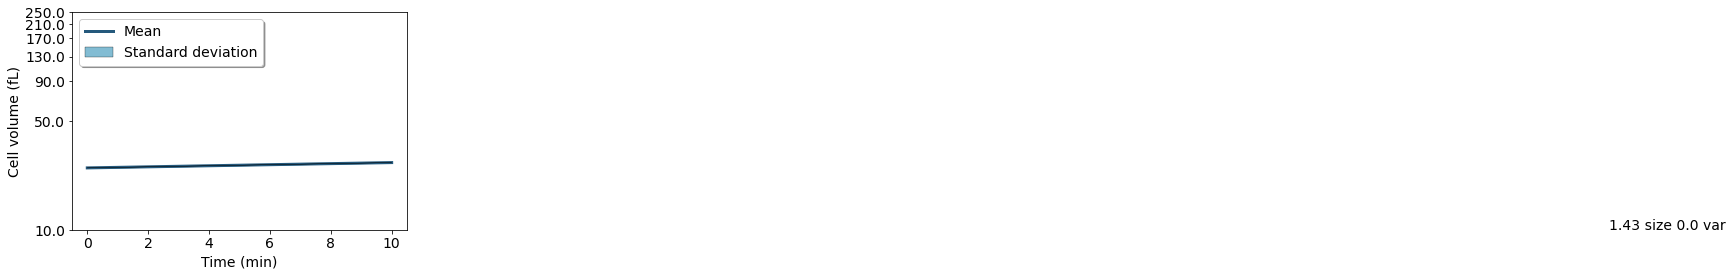

In [9]:
from joblib import Parallel, delayed
from time import time


def main():

    starttime = time()
    pop = simulation(1,10)
    stoptime = time()
    print(len(pop))
    print(stoptime-starttime,' s')
    
    save_dir = './BGM_sim/'
    filename_sim = 'plot'
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    plot_X_life(pop, 'B_R', 'Time (min)', 'Cell volume (fL)', 'lifecycle_V_'+filename_sim+'.pdf', 1, 10000, False,save_dir)
    Parallel(n_jobs=-1)(delayed(plot_species)(pop[cell_nr],save_dir,cell_nr) for cell_nr in range(len(pop)))
    
def simulation(init_number, duration):
    population = []
    old_daughters = [cell('init_species',duration,0) for i in range(init_number)]
    new_daughters = []
    
    while old_daughters:
        results = Parallel(n_jobs=-1)(delayed(c.simulate)() for c in old_daughters)
        population.extend([res[0] for res in results])
        daughters = [res[1] for res in results]
        for d_list in daughters:
            new_daughters.extend(d_list)
        print('collected: ',len(new_daughters))
        old_daughters=new_daughters
        new_daughters=[]
        break

    return population


if __name__=='__main__':
    main()

In [ ]:
collected:  24
collected:  122
collected:  303
collected:  452
collected:  401
collected:  248
collected:  89
collected:  18
collected:  1
collected:  0
1660
11.535976648330688  s
1.5093267266801176 0.1793261014770128
